Start with loading the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
from pykalman import KalmanFilter


Read Data

In [2]:

data = pd.read_csv("../data/2024-11-25-1732560701581.csv")
data.head()


,time_ms,acc_x_mg,acc_y_mg,acc_z_mg,gyro_x_mdps,gyro_y_mdps,gyro_z_mdps,mag_x_mgauss,mag_y_mgauss,mag_z_mgauss
0,1844,0.000590,-0.000581,0.000434,-0.000009,0.000006,0.000007,-0.105069,0.052649,0.133121
1,1844,0.135760,-0.135246,0.100305,-0.002560,0.001945,0.002679,-24.345341,12.196267,30.852861
2,1844,0.980066,-0.977131,0.721474,-0.021957,0.019907,0.030839,-175.853195,88.102921,222.828873
3,1844,2.681536,-2.643853,1.955608,-0.059769,0.064866,0.097326,-481.370575,241.213394,609.783142
4,1844,4.627987,-4.526622,3.364781,-0.085278,0.104296,0.129485,-835.309631,418.534424,1057.867188


First and last 800 ms of data need to be trimmed

In [3]:
trim_start = 800
trim_end = 800


data = data.iloc[trim_start:-trim_end]

looking at data

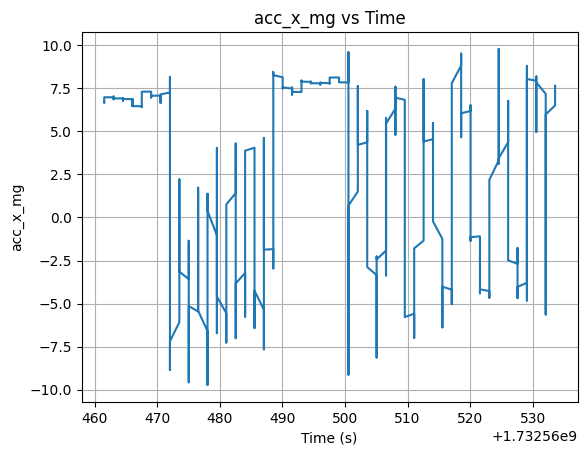

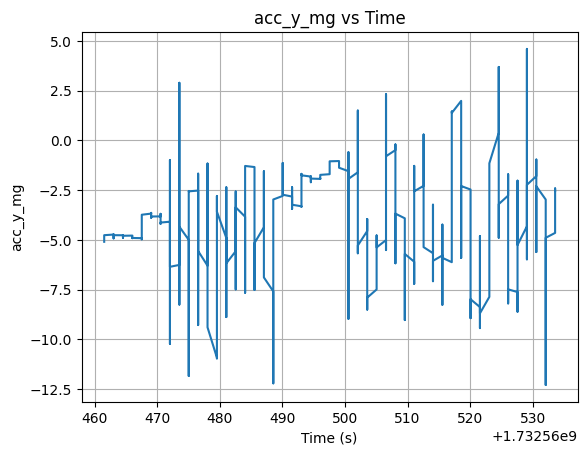

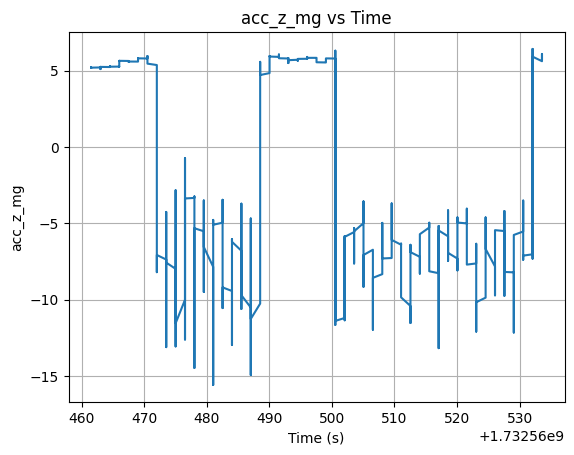

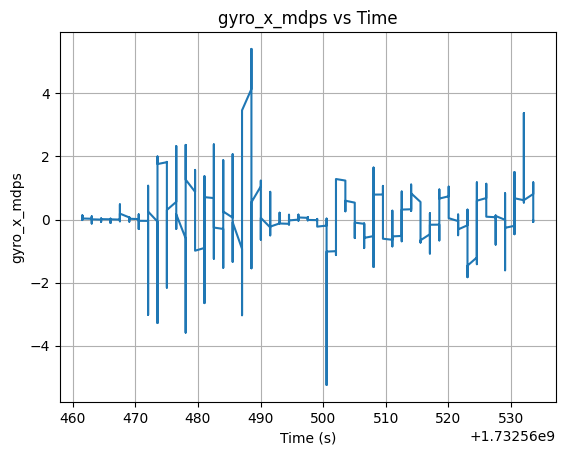

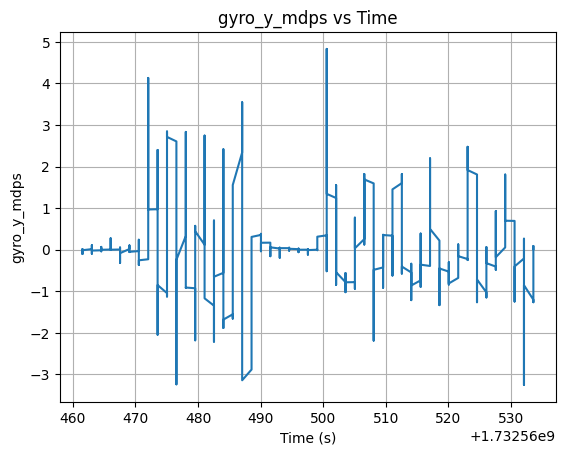

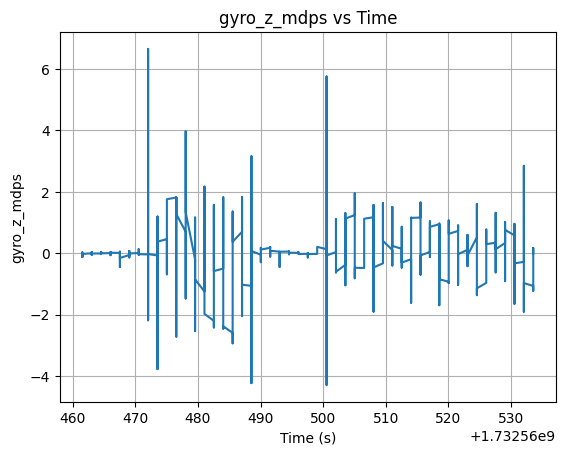

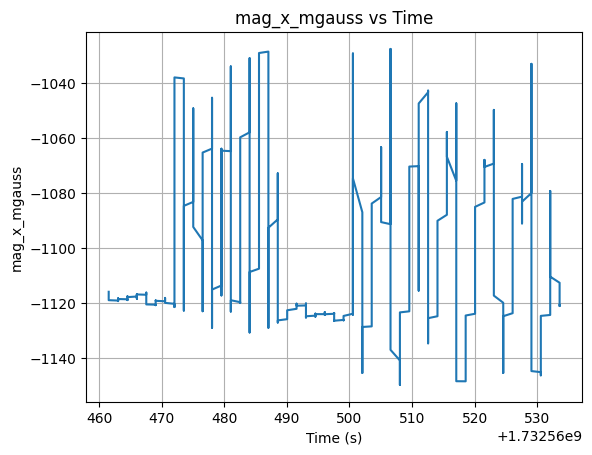

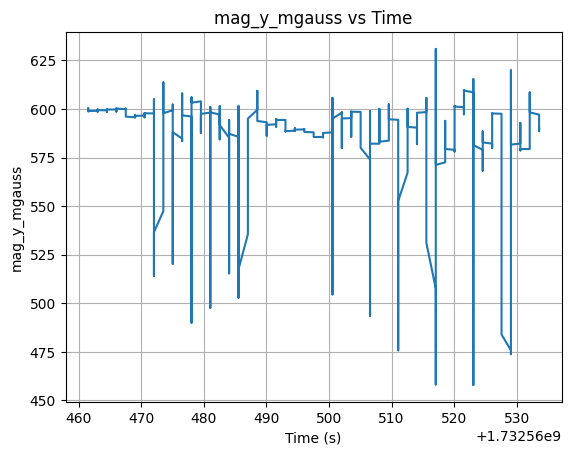

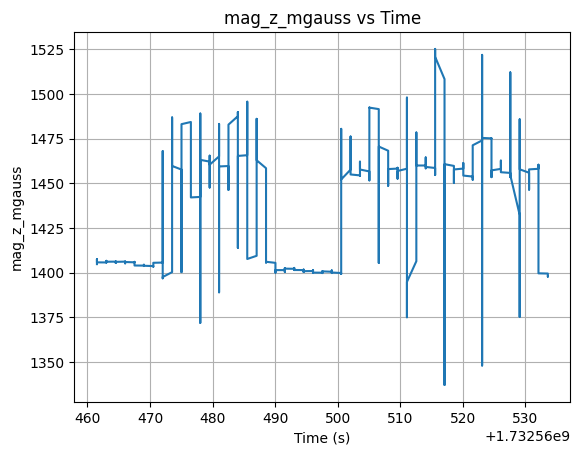

In [7]:
data['time_s'] = data['time_ms'] / 1000

for column in data.columns:
    if column != 'time_ms' and column != 'time_s':
        plt.figure()
        plt.plot(data['time_s'], data[column])
        plt.xlabel('Time (s)')
        plt.ylabel(column)
        plt.title(f'{column} vs Time')
        plt.grid(True)
        plt.show()

Smooth data

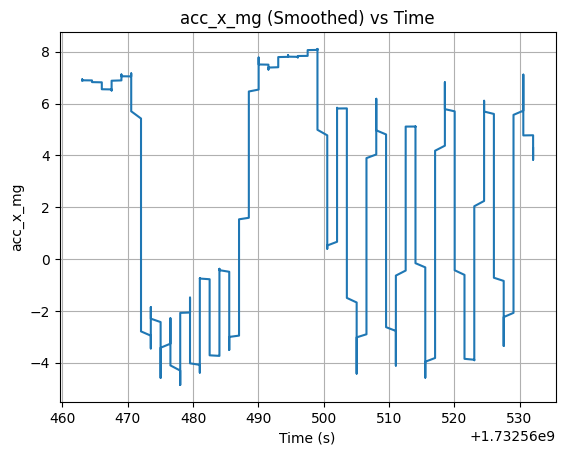

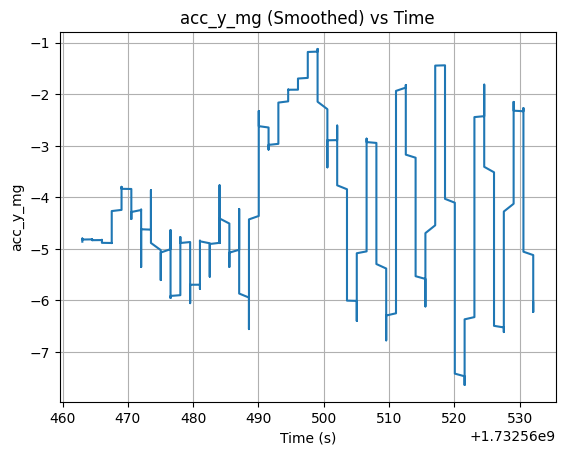

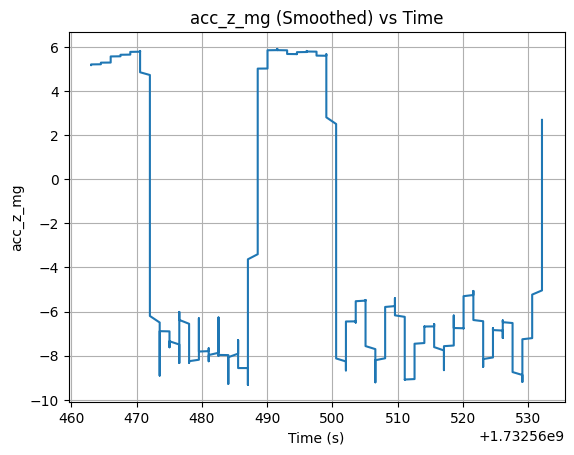

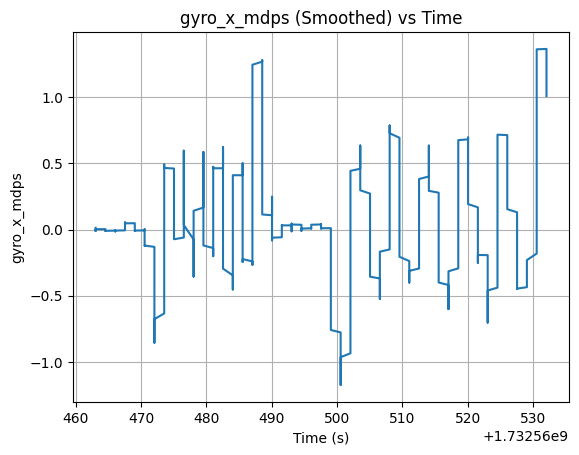

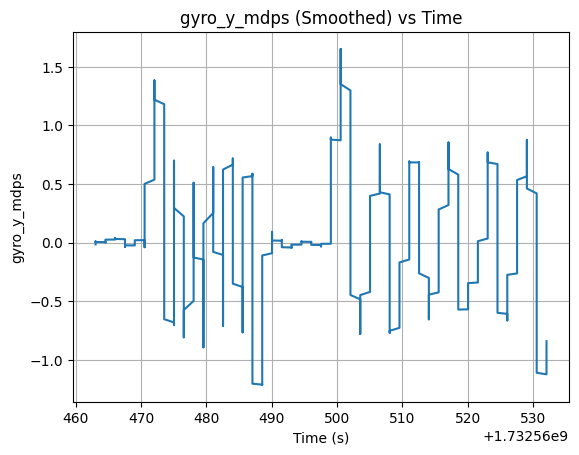

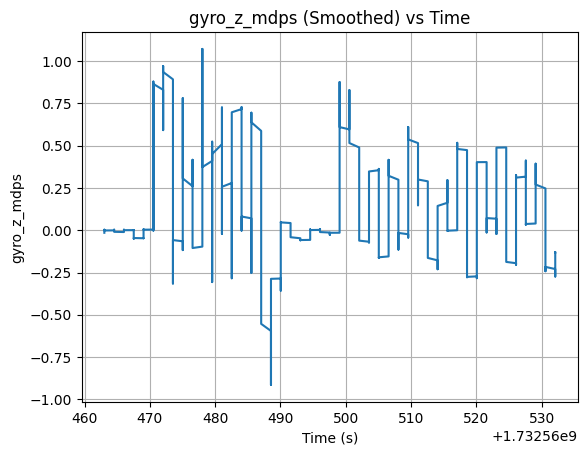

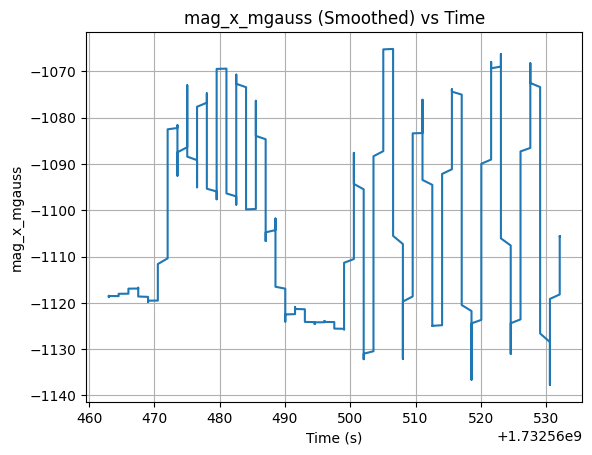

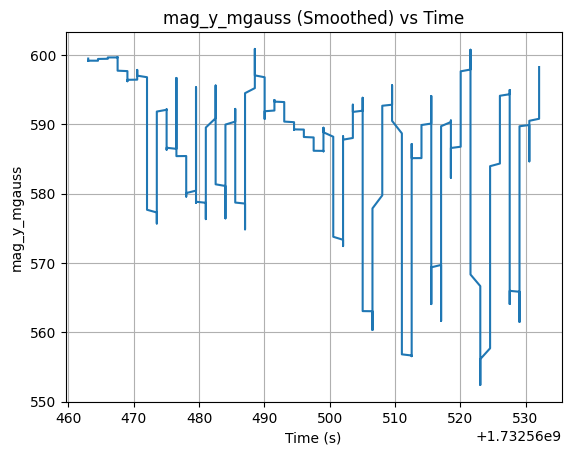

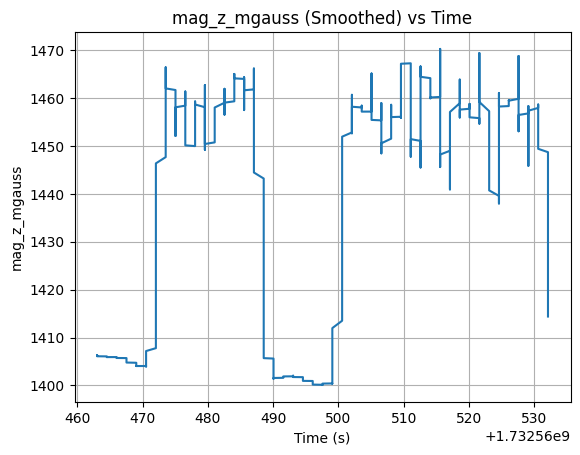

In [7]:

# Smooth the columns using a rolling mean
window_size = 50  # Adjust the window size as needed
data_smoothed = data.copy()

# Apply rolling mean to all columns except 'time_ms' and 'time_s'
for column in data.columns:
    if column != 'time_ms' and column != 'time_s':
        data_smoothed[column] = data[column].rolling(window=window_size, center=True).mean()

# Plot the smoothed data
for column in data_smoothed.columns:
    if column != 'time_ms' and column != 'time_s':
        plt.figure()
        plt.plot(data['time_s'], data_smoothed[column])
        plt.xlabel('Time (s)')
        plt.ylabel(column)
        plt.title(f'{column} (Smoothed) vs Time')
        plt.grid(True)
        plt.show()


**Pre-processing**

Trimming data to get rid of artifacts from the begining and end of data

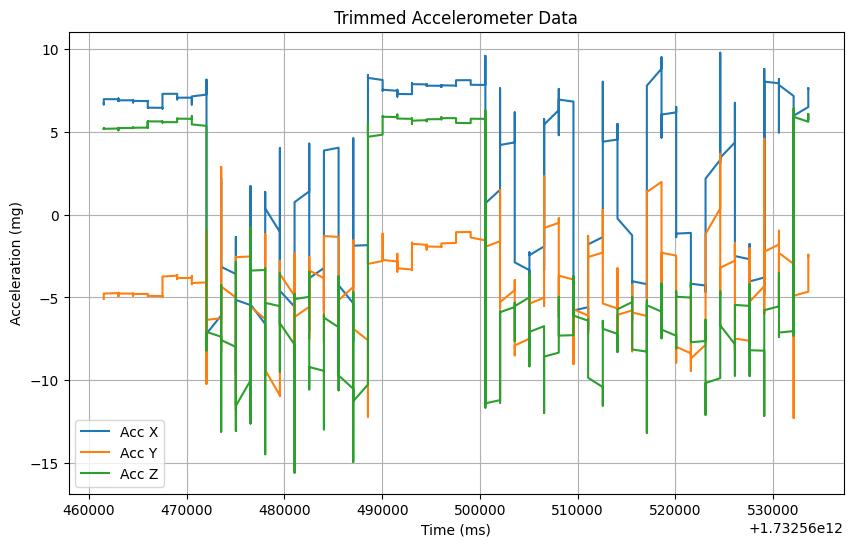

In [14]:

trim_start = 800
trim_end = 800


trimmed_data = data.iloc[trim_start:-trim_end]


plt.figure(figsize=(10, 6))
for axis in ['x', 'y', 'z']:
    plt.plot(trimmed_data['time_ms'], trimmed_data[f'acc_{axis}_mg'], label=f'Acc {axis.upper()}')

plt.title('Trimmed Accelerometer Data')
plt.xlabel('Time (ms)')
plt.ylabel('Acceleration (mg)')
plt.legend()
plt.grid()
plt.show()




 Threshold-Based Event Detection

C:\Users\iddos\AppData\Local\Temp\ipykernel_16044\1634137658.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data['acc_magnitude'] = np.sqrt(


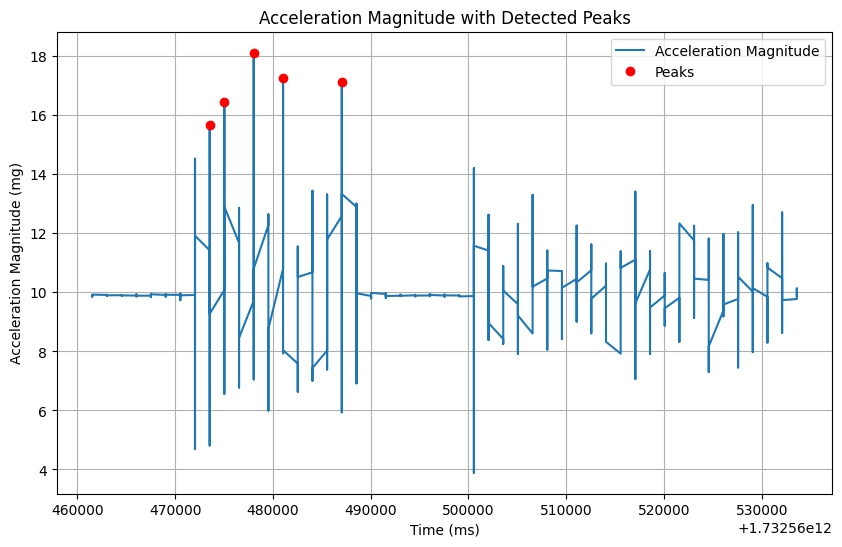

In [103]:


trimmed_data['acc_magnitude'] = np.sqrt(
    trimmed_data['acc_x_mg']**2 +
    trimmed_data['acc_y_mg']**2 +
    trimmed_data['acc_z_mg']**2
)


peak_threshold = 15 
peaks, _ = find_peaks(trimmed_data['acc_magnitude'], height=peak_threshold)


plt.figure(figsize=(10, 6))
plt.plot(trimmed_data['time_ms'], trimmed_data['acc_magnitude'], label='Acceleration Magnitude')
plt.plot(trimmed_data['time_ms'].iloc[peaks], trimmed_data['acc_magnitude'].iloc[peaks], 'ro', label='Peaks')
plt.title('Acceleration Magnitude with Detected Peaks')
plt.xlabel('Time (ms)')
plt.ylabel('Acceleration Magnitude (mg)')
plt.legend()
plt.grid()
plt.show()



Angular Velocity Analysis

C:\Users\iddos\AppData\Local\Temp\ipykernel_16044\2738633528.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data['gyro_magnitude'] = np.sqrt(


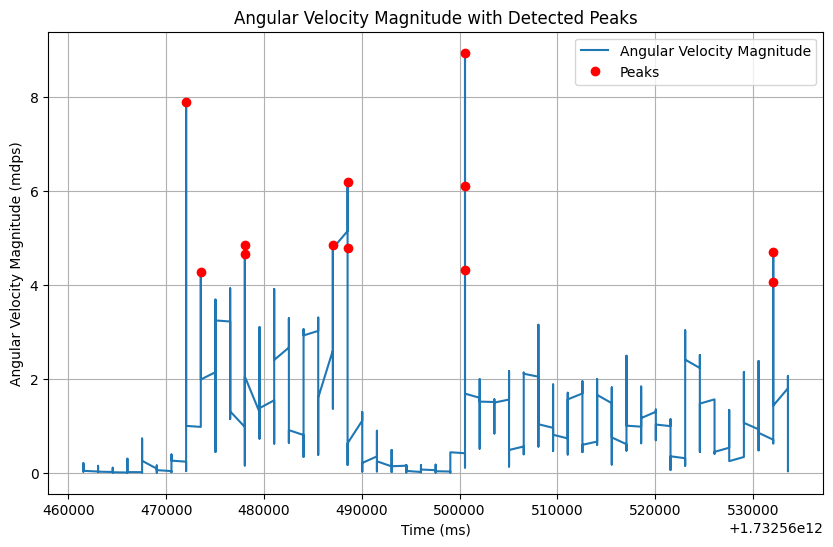

In [107]:
trimmed_data['gyro_magnitude'] = np.sqrt(
    trimmed_data['gyro_x_mdps']**2 +
    trimmed_data['gyro_y_mdps']**2 +
    trimmed_data['gyro_z_mdps']**2
)


gyro_peak_threshold = 4
gyro_peaks, _ = find_peaks(trimmed_data['gyro_magnitude'], height=gyro_peak_threshold)


plt.figure(figsize=(10, 6))
plt.plot(trimmed_data['time_ms'], trimmed_data['gyro_magnitude'], label='Angular Velocity Magnitude')
plt.plot(trimmed_data['time_ms'].iloc[gyro_peaks], trimmed_data['gyro_magnitude'].iloc[gyro_peaks], 'ro', label='Peaks')
plt.title('Angular Velocity Magnitude with Detected Peaks')
plt.xlabel('Time (ms)')
plt.ylabel('Angular Velocity Magnitude (mdps)')
plt.legend()
plt.grid()
plt.show()


frequency analysis

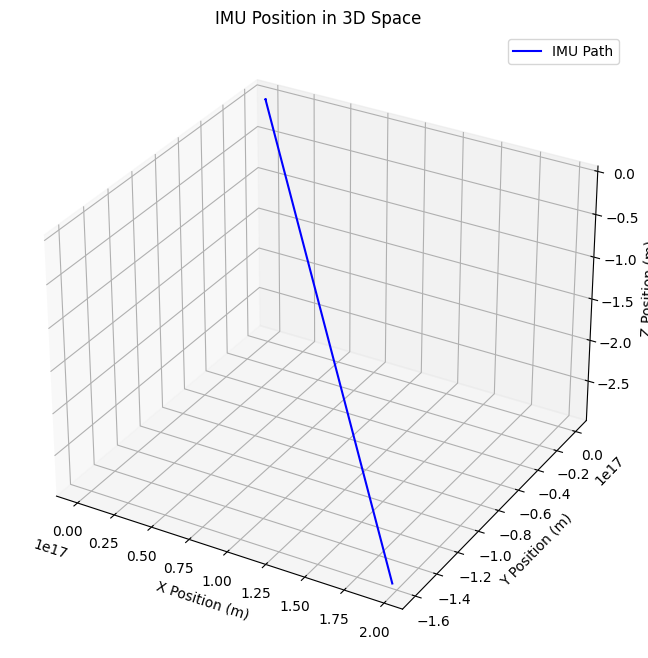

In [101]:

# Define constants
g = 9.81  # Gravity in m/s^2

# Define the low-pass filter
def butter_lowpass_filter(data, cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    if len(data) < len(b) + len(a):
        raise ValueError("Data length is too short for the filter order.")
    return filtfilt(b, a, data)

# Load and preprocess data
imu_data = data
imu_data = imu_data.sort_values(by='time_ms').drop_duplicates(subset=['time_ms'])
time_seconds = imu_data['time_ms'].values / 1000

# Compute sampling frequency
time_intervals = np.diff(time_seconds)
valid_intervals = time_intervals[time_intervals > 0]
sampling_interval = valid_intervals.mean()
fs = 1 / sampling_interval

# Apply low-pass filter
cutoff = min(5, 0.4 * fs)
for axis in ['x', 'y', 'z']:
    imu_data[f'filtered_acc_{axis}'] = butter_lowpass_filter(imu_data[f'acc_{axis}_mg'], cutoff, fs)
    imu_data[f'filtered_gyro_{axis}'] = butter_lowpass_filter(imu_data[f'gyro_{axis}_mdps'], cutoff, fs)

# Convert accelerometer data to m/s^2 and gyroscope data to radians
for axis in ['x', 'y', 'z']:
    imu_data[f'filtered_acc_{axis}'] *= g / 1000
    imu_data[f'filtered_gyro_{axis}'] = np.deg2rad(imu_data[f'filtered_gyro_{axis}'])

# Initialize position and velocity arrays
position = np.zeros((len(imu_data), 3))
velocity = np.zeros((len(imu_data), 3))

# Compute velocity and position
for i in range(1, len(imu_data)):
    dt = time_seconds[i] - time_seconds[i - 1]
    for j, axis in enumerate(['x', 'y', 'z']):        
        acc = imu_data[f'filtered_acc_{axis}'].iloc[i]
        if axis == 'z':
            acc -= g  # Remove gravity
        velocity[i, j] = velocity[i - 1, j] + acc * dt
        position[i, j] = position[i - 1, j] + velocity[i, j] * dt

# Plot the 3D path
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(position[:, 0], position[:, 1], position[:, 2], label='IMU Path', color='blue')
ax.set_title('IMU Position in 3D Space')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')
ax.legend()
plt.show()
